# Forecasting & Predictive Analysis
## Projecting Future Update Trends

This notebook implements time series forecasting to predict future decay patterns.

## Section 1: Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv("../data/feature_engineered_monthly.csv")
df['year_month'] = pd.to_datetime(df['year_month'])
df = df.sort_values(['state', 'year_month'])

df_priority = pd.read_csv("../data/state_priority_classification_final.csv")

print(f"Data loaded: {df.shape[0]} rows")
print(f"Date range: {df['year_month'].min()} to {df['year_month'].max()}")

Data loaded: 573 rows
Date range: 2025-01-01 00:00:00 to 2025-12-01 00:00:00


## Section 2: Select Priority States for Forecasting

In [2]:
# Focus on top 10 decaying states
priority_states = df_priority[df_priority['state_status'] == 'DECAYING'].nsmallest(10, 'priority_rank')['state'].tolist()

print(f"Forecasting for {len(priority_states)} priority decaying states:")
for i, state in enumerate(priority_states, 1):
    print(f"{i}. {state}")

Forecasting for 10 priority decaying states:
1. PUDUCHERRY
2. ANDAMAN AND NICOBAR ISLANDS
3. HIMACHAL PRADESH
4. CHANDIGARH
5. ANDHRA PRADESH
6. DADRA AND NAGAR HAVELI AND DAMAN AND DIU
7. ODISHA
8. TAMIL NADU
9. GOA
10. LADAKH


## Section 3: ARIMA Forecasting Function

In [3]:
def forecast_state_arima(state_name, data, periods=3):
    """
    Forecast update intensity using ARIMA model.
    
    Args:
        state_name: Name of the state
        data: Full dataframe
        periods: Number of months to forecast
    
    Returns:
        Dictionary with historical data, forecast, and confidence intervals
    """
    # Filter state data
    state_df = data[data['state'] == state_name].sort_values('year_month').copy()
    
    # Remove any NaT values
    state_df = state_df[state_df['year_month'].notna()]
    
    if len(state_df) < 6:
        return None
    
    # Prepare time series with proper datetime index
    ts = state_df[['year_month', 'update_intensity']].copy()
    ts = ts.set_index('year_month')['update_intensity']
    
    # Ensure index is datetime
    if not isinstance(ts.index, pd.DatetimeIndex):
        ts.index = pd.to_datetime(ts.index)
    
    # Remove any remaining NaT from index
    ts = ts[ts.index.notna()]
    
    if len(ts) < 6:
        return None
    
    try:
        # Fit ARIMA model (auto-tuned to simple (1,0,1))
        model = ARIMA(ts, order=(1, 0, 1))
        fitted_model = model.fit()
        
        # Forecast
        forecast_result = fitted_model.forecast(steps=periods)
        
        # Get confidence intervals
        forecast_detail = fitted_model.get_forecast(steps=periods)
        forecast_ci = forecast_detail.conf_int()
        
        # Create future dates - FIXED: using relativedelta for proper month addition
        last_date = ts.index[-1]
        future_dates = [last_date + relativedelta(months=i) for i in range(1, periods + 1)]
        future_dates = pd.DatetimeIndex(future_dates)
        
        return {
            'state': state_name,
            'historical_dates': ts.index,
            'historical_values': ts.values,
            'forecast_dates': future_dates,
            'forecast_values': forecast_result.values,
            'lower_ci': forecast_ci.iloc[:, 0].values,
            'upper_ci': forecast_ci.iloc[:, 1].values,
            'model_aic': fitted_model.aic
        }
    except Exception as e:
        print(f"Error forecasting {state_name}: {str(e)}")
        return None

print("ARIMA forecasting function defined")

ARIMA forecasting function defined


## Section 4: Generate Forecasts

In [4]:
# Generate forecasts for priority states
forecasts = {}

for state in priority_states:
    result = forecast_state_arima(state, df, periods=3)
    if result:
        forecasts[state] = result
        print(f"✓ Forecast generated for {state} (AIC: {result['model_aic']:.2f})")

print(f"\nSuccessfully forecasted {len(forecasts)} states")

✓ Forecast generated for PUDUCHERRY (AIC: 258.22)
✓ Forecast generated for ANDAMAN AND NICOBAR ISLANDS (AIC: 222.30)
✓ Forecast generated for HIMACHAL PRADESH (AIC: 207.72)
✓ Forecast generated for CHANDIGARH (AIC: 205.23)
✓ Forecast generated for ANDHRA PRADESH (AIC: 193.38)
✓ Forecast generated for DADRA AND NAGAR HAVELI AND DAMAN AND DIU (AIC: 187.24)
✓ Forecast generated for ODISHA (AIC: 188.80)
✓ Forecast generated for TAMIL NADU (AIC: 185.62)
✓ Forecast generated for GOA (AIC: 181.05)
✓ Forecast generated for LADAKH (AIC: 179.78)

Successfully forecasted 10 states


## Section 5: Visualize Forecasts

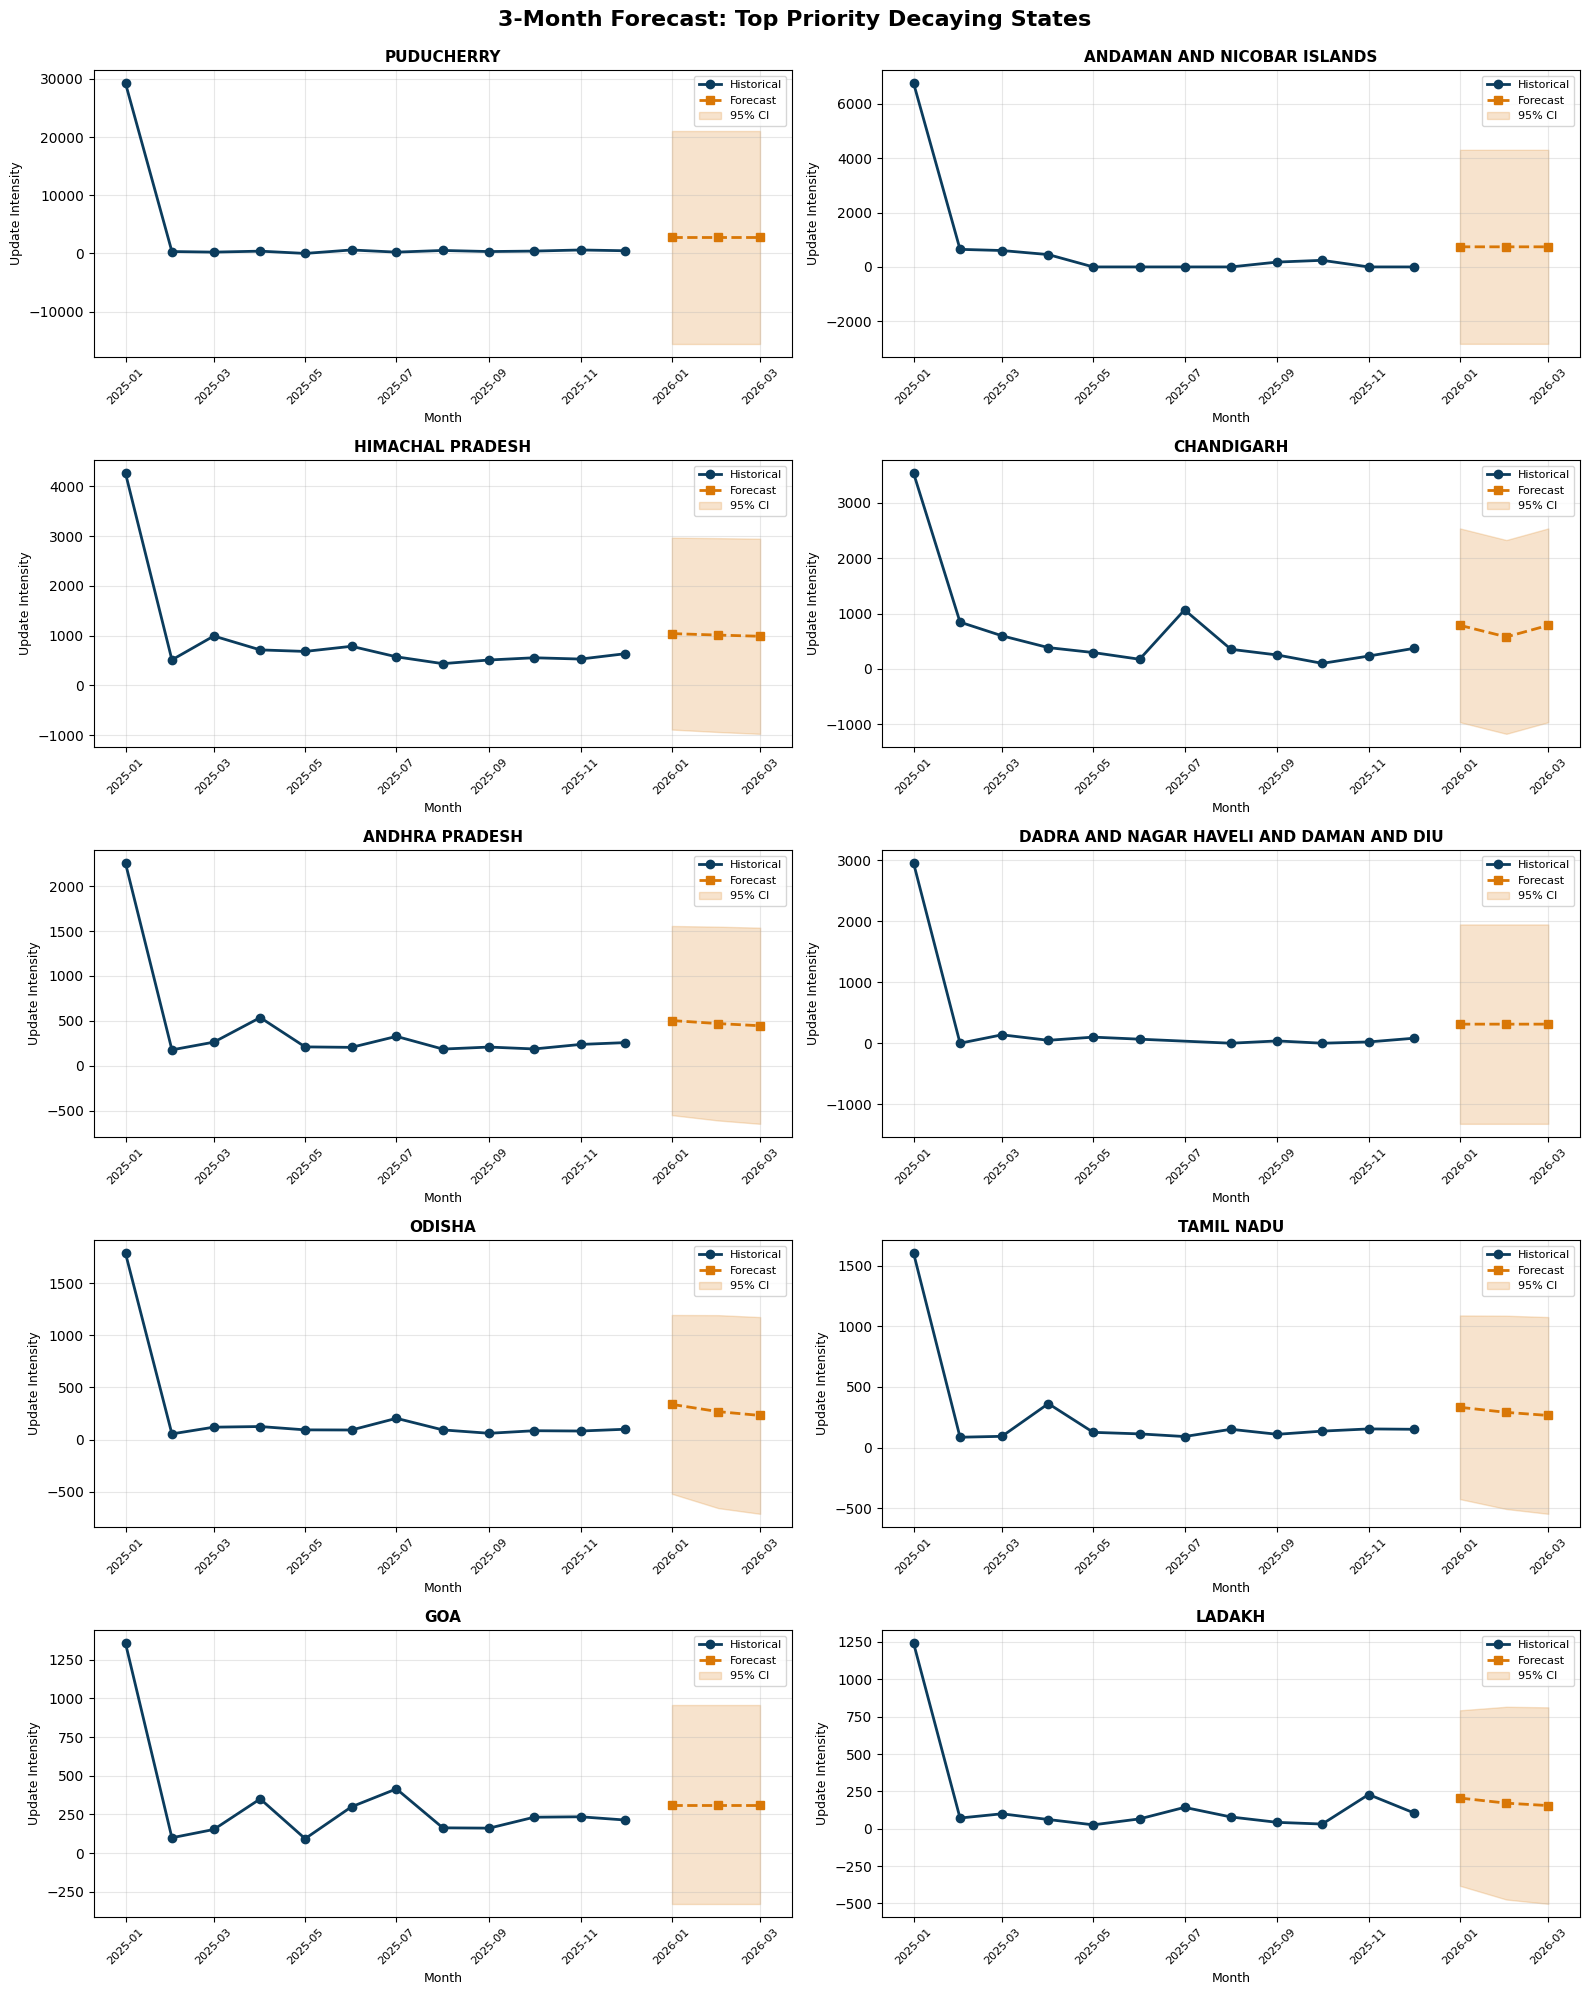

Forecast visualization saved to: ../data/forecasts_visualization.png


In [5]:
# Create forecast visualizations
num_forecasts = len(forecasts)
if num_forecasts > 0:
    rows = (num_forecasts + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(16, rows * 4))
    axes = axes.flatten() if num_forecasts > 1 else [axes]
    
    for idx, (state, forecast_data) in enumerate(list(forecasts.items())[:10]):
        ax = axes[idx]
        
        # Plot historical data
        ax.plot(forecast_data['historical_dates'], 
                forecast_data['historical_values'], 
                marker='o', 
                label='Historical',
                color='#0B3C5D',
                linewidth=2)
        
        # Plot forecast
        ax.plot(forecast_data['forecast_dates'], 
                forecast_data['forecast_values'], 
                marker='s', 
                label='Forecast',
                color='#D97706',
                linewidth=2,
                linestyle='--')
        
        # Plot confidence interval
        ax.fill_between(forecast_data['forecast_dates'],
                         forecast_data['lower_ci'],
                         forecast_data['upper_ci'],
                         alpha=0.2,
                         color='#D97706',
                         label='95% CI')
        
        ax.set_title(state, fontweight='bold', fontsize=11)
        ax.set_xlabel('Month', fontsize=9)
        ax.set_ylabel('Update Intensity', fontsize=9)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
    
    # Hide unused subplots
    for idx in range(num_forecasts, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('3-Month Forecast: Top Priority Decaying States', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('../data/forecasts_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Forecast visualization saved to: ../data/forecasts_visualization.png")
else:
    print("No forecasts generated. Skipping visualization.")

## Section 6: Scenario Analysis
### What-if analysis for intervention impact

In [6]:
# Scenario: If intervention increases update rate by 20%
if len(forecasts) > 0:
    scenario_results = []
    
    for state, forecast_data in forecasts.items():
        current_forecast = forecast_data['forecast_values'][-1]
        
        # Scenario 1: +20% improvement
        improved_20 = current_forecast * 1.20
        
        # Scenario 2: +50% improvement
        improved_50 = current_forecast * 1.50
        
        # Current trajectory (no intervention)
        baseline = current_forecast
        
        scenario_results.append({
            'state': state,
            'baseline_forecast': baseline,
            'scenario_20pct': improved_20,
            'scenario_50pct': improved_50,
            'improvement_needed_for_median': 0.05 / baseline if baseline > 0 else np.inf
        })
    
    df_scenarios = pd.DataFrame(scenario_results)
    
    print("\nScenario Analysis: Impact of Interventions")
    print("="*70)
    print(df_scenarios.to_string(index=False))
    
    # Save scenario analysis
    df_scenarios.to_csv('../data/forecast_scenarios.csv', index=False)
    print("\nScenario analysis saved to: ../data/forecast_scenarios.csv")
else:
    print("No forecasts available for scenario analysis.")


Scenario Analysis: Impact of Interventions
                                   state  baseline_forecast  scenario_20pct  scenario_50pct  improvement_needed_for_median
                              PUDUCHERRY        2774.371010     3329.245212     4161.556515                       0.000018
             ANDAMAN AND NICOBAR ISLANDS         739.093252      886.911902     1108.639878                       0.000068
                        HIMACHAL PRADESH         988.690276     1186.428331     1483.035413                       0.000051
                              CHANDIGARH         788.188992      945.826790     1182.283488                       0.000063
                          ANDHRA PRADESH         445.455783      534.546939      668.183674                       0.000112
DADRA AND NAGAR HAVELI AND DAMAN AND DIU         312.971857      375.566228      469.457785                       0.000160
                                  ODISHA         231.296626      277.555951      346.944939    

## Section 7: Export Forecast Data

In [7]:
# Compile all forecasts into single dataframe
if len(forecasts) > 0:
    forecast_records = []
    
    for state, data in forecasts.items():
        for i, date in enumerate(data['forecast_dates']):
            forecast_records.append({
                'state': state,
                'forecast_month': date,
                'forecast_value': data['forecast_values'][i],
                'lower_bound': data['lower_ci'][i],
                'upper_bound': data['upper_ci'][i]
            })
    
    df_forecast_export = pd.DataFrame(forecast_records)
    df_forecast_export.to_csv('../data/state_forecasts_3month.csv', index=False)
    
    print("Forecast data exported to: ../data/state_forecasts_3month.csv")
    print(f"Total forecast records: {len(df_forecast_export)}")
else:
    print("No forecast data to export.")

Forecast data exported to: ../data/state_forecasts_3month.csv
Total forecast records: 30
